In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [2]:
food_price_df = pd.read_csv("C:\\Users\\HomePC\\Desktop\\my_file\\food price in nigeria\\nig_food_price_2007_to_2025(clean).csv")

In [3]:
# pick out columns to be use for the analysis
food_price_data_df = food_price_df[['price_date','state','market_name','bread','cassava_meal',
                                    'cowpeas','gari','groundnuts','maize','rice','sorghum','yam']]
food_price_data_df

,price_date,state,market_name,bread,cassava_meal,cowpeas,gari,groundnuts,maize,rice,sorghum,yam
0,1/1/2007,Abia,Aba,73.2175,10096.7775,10927.9175,6947.3150,24707.1200,3026.9925,341.0200,3581.4375,152.2525
1,2/1/2007,Abia,Aba,72.2450,10107.6475,10902.3975,6937.6550,24800.9650,3049.6700,337.2950,3606.9975,151.2600
2,3/1/2007,Abia,Aba,71.3850,10096.6525,10730.5825,6874.6900,24798.9775,3016.4550,335.9275,3558.7075,150.9675
3,4/1/2007,Abia,Aba,75.1175,9999.2800,10586.8925,6850.6875,24305.2050,3010.2950,343.1650,3552.1750,154.9700
4,5/1/2007,Abia,Aba,69.8175,10071.5050,10743.7775,6870.2925,24921.2300,3031.5275,337.6275,3563.9050,151.5375
...,...,...,...,...,...,...,...,...,...,...,...,...
13537,2/1/2025,Market Average,Market Average,285.7375,42133.3625,6838.7375,24024.8325,47241.2650,29826.7050,5457.4500,37135.6625,3371.1525
13538,3/1/2025,Market Average,Market Average,280.6150,42231.4700,6945.4225,24102.1025,47885.4525,29833.5700,5343.9500,37183.1350,3326.5025
13539,4/1/2025,Market Average,Market Average,265.4625,42383.2000,6592.9350,23665.5950,48401.6650,29889.8625,5355.3325,36740.2500,3432.6100
13540,5/1/2025,Market Average,Market Average,268.3675,43056.5450,6374.1700,23780.1300,48755.8375,30218.6250,5442.9400,37143.9300,3534.3725


In [4]:
# filter data by state and market
selected_state = 'Borno'
selected_market = 'Monday'
ts = food_price_data_df[
                                (food_price_data_df['state'] == selected_state) & 
                                (food_price_data_df['market_name'] == selected_market)
                                 ]
ts

,price_date,state,market_name,bread,cassava_meal,cowpeas,gari,groundnuts,maize,rice,sorghum,yam
10434,1/1/2007,Borno,Monday,93.9000,10586.5825,12259.3650,7593.2850,27200.3275,3742.6050,462.8175,3496.1200,147.8225
10435,2/1/2007,Borno,Monday,92.9075,10631.3800,12540.3850,7585.1725,27258.8750,3763.7875,457.6075,3512.4825,149.4600
10436,3/1/2007,Borno,Monday,90.5250,10595.0375,12319.7200,7551.9175,27193.4025,3709.4200,451.1725,3452.5575,147.5275
10437,4/1/2007,Borno,Monday,92.2850,10641.2250,12145.3625,7573.8300,26978.7675,3709.1550,455.3850,3466.4200,150.8100
10438,5/1/2007,Borno,Monday,92.2650,10581.3225,12302.9750,7587.4175,27165.6375,3754.7550,454.6675,3506.3275,152.6050
...,...,...,...,...,...,...,...,...,...,...,...,...
10651,2/1/2025,Borno,Monday,438.7600,38655.4025,4098.4000,21173.0100,37781.3075,25636.6575,8750.0000,24525.9775,2450.0000
10652,3/1/2025,Borno,Monday,419.2350,38710.9750,4063.8325,21127.5075,38124.2500,25481.2050,8374.3200,24295.8150,2525.8075
10653,4/1/2025,Borno,Monday,380.3025,38798.4975,3962.5225,20796.3725,39249.6400,25439.1550,7700.0000,24002.0125,2850.0000
10654,5/1/2025,Borno,Monday,268.9700,39359.5675,3959.6225,19860.9000,45797.8525,25621.4775,6719.3825,23940.4175,3056.9650


In [5]:
ts.isna().sum()

price_date      0
state           0
market_name     0
bread           0
cassava_meal    0
cowpeas         0
gari            0
groundnuts      0
maize           0
rice            0
sorghum         0
yam             0
dtype: int64

In [6]:
# Convert Dates and Sort Time Series
ts['price_date'] = pd.to_datetime(ts['price_date'])             # Convert string dates to datetime objects
ts = ts.sort_values('price_date').reset_index(drop=True)  # Sort by date and reset index

In [7]:
# Data types of each column
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price_date    222 non-null    datetime64[ns]
 1   state         222 non-null    object        
 2   market_name   222 non-null    object        
 3   bread         222 non-null    float64       
 4   cassava_meal  222 non-null    float64       
 5   cowpeas       222 non-null    float64       
 6   gari          222 non-null    float64       
 7   groundnuts    222 non-null    float64       
 8   maize         222 non-null    float64       
 9   rice          222 non-null    float64       
 10  sorghum       222 non-null    float64       
 11  yam           222 non-null    float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 20.9+ KB


In [8]:
# Set date as index
ts.set_index('price_date', inplace=True)

In [9]:
# Using the 'maize' price as a case study for forecasting
ts_data = ts['maize']
ts_data.head()

price_date
2007-01-01    3742.6050
2007-02-01    3763.7875
2007-03-01    3709.4200
2007-04-01    3709.1550
2007-05-01    3754.7550
Name: maize, dtype: float64

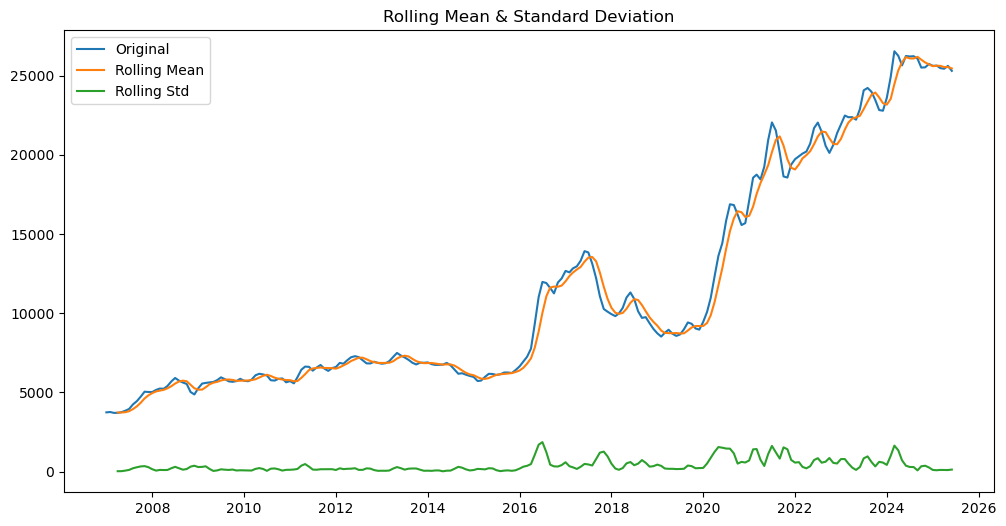

In [10]:
# Plot rolling statistics to visually check stationarity
def plot_rolling_stats(series, window=4):
    # Calculate rolling statistics
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

plot_rolling_stats(ts_data)

In [11]:
# Check stationarity using the Augmented Dickey-Fuller (ADF) test

adf_result = adfuller(ts_data)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

for key, value in adf_result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

ADF Statistic: -0.365660177276545
p-value: 0.9156763486609035
Critical Value (1%): -3.462
Critical Value (5%): -2.876
Critical Value (10%): -2.574


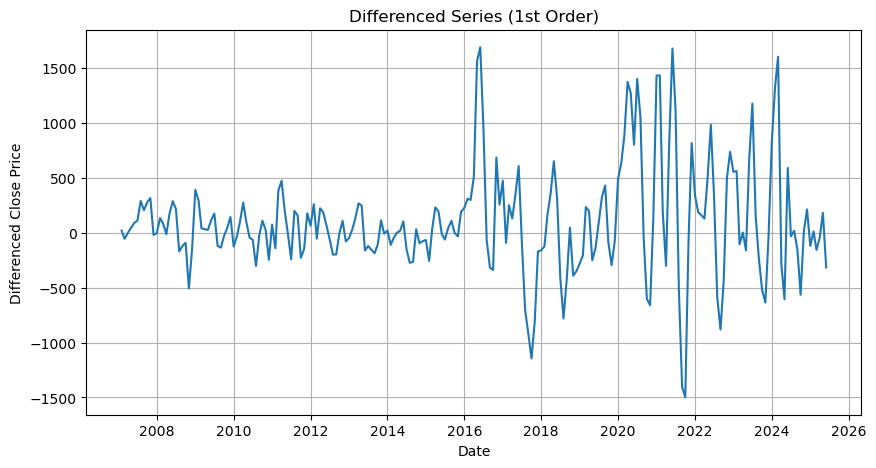

In [12]:
# First-order differencing
ts_diff = ts_data.diff().dropna()

plt.figure(figsize=(10,5))
plt.plot(ts_diff)
plt.title('Differenced Series (1st Order)')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.grid(True)
plt.show()

In [13]:
# ADF test on differenced data
adf_diff = adfuller(ts_diff)

print("ADF Statistic (Differenced):", adf_diff[0])
print("p-value:", adf_diff[1])
for key, val in adf_diff[4].items():
    print(f"Critical Value ({key}): {val:.3f}")

ADF Statistic (Differenced): -2.891158991051988
p-value: 0.046385788095380236
Critical Value (1%): -3.462
Critical Value (5%): -2.876
Critical Value (10%): -2.574


In [14]:
p_values = range(0, 3)
q_values = range(0, 3)

d = 1
D = 1
s = 12  # monthly seasonality

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_res = None

for p in p_values:
    for q in q_values:
        try:
            model = SARIMAX(
                ts_data,
                order=(p, d, q),
                seasonal_order=(1, D, 1, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)
            print(f"SARIMA({p},{d},{q})(1,{D},1,{s}) AIC={res.aic:.2f}")

            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, d, q)
                best_seasonal_order = (1, D, 1, s)
                best_res = res

        except Exception as e:
            print(f"SARIMA({p},{d},{q}) failed: {e}")

print("\nBest SARIMA model:")
print("Order:", best_order)
print("Seasonal order:", best_seasonal_order)
print("AIC:", best_aic)
print(best_res.summary())


SARIMA(0,1,0)(1,1,1,12) AIC=2983.96
SARIMA(0,1,1)(1,1,1,12) AIC=2874.11
SARIMA(0,1,2)(1,1,1,12) AIC=2852.26
SARIMA(1,1,0)(1,1,1,12) AIC=2915.22
SARIMA(1,1,1)(1,1,1,12) AIC=2868.26
SARIMA(1,1,2)(1,1,1,12) AIC=2854.25
SARIMA(2,1,0)(1,1,1,12) AIC=2861.93
SARIMA(2,1,1)(1,1,1,12) AIC=2862.09
SARIMA(2,1,2)(1,1,1,12) AIC=2850.29

Best SARIMA model:
Order: (2, 1, 2)
Seasonal order: (1, 1, 1, 12)
AIC: 2850.290136519735
                                      SARIMAX Results                                       
Dep. Variable:                                maize   No. Observations:                  222
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1418.145
Date:                              Fri, 09 Jan 2026   AIC                           2850.290
Time:                                      09:32:50   BIC                           2873.165
Sample:                                  01-01-2007   HQIC                          2859.553
                            

In [15]:
# Model Evaluation

# Extract fitted values
fitted = best_res.fittedvalues

# Align actual data to the fitted values index
actual = ts_data.loc[fitted.index]

mae_in = mean_absolute_error(actual, fitted)
rmse_in = np.sqrt(mean_squared_error(actual, fitted))

print("In-sample MAE:", mae_in)
print("In-sample RMSE:", rmse_in)


In-sample MAE: 283.6107656701739
In-sample RMSE: 460.07294392912627


In [16]:
# Forecast next 30 days
forecast_steps = 30
forecast = res.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

In [22]:
# SARIMAX Forecast Table

# Find the last date in the historical time series
last_date = ts.index[-1]
print("Last date in historical data:", last_date)

# Generate future dates for the forecast horizon (only business days)
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                               periods=forecast_steps, freq='M')

# Create forecast object
forecast = res.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Combine forecasted values and confidence intervals into a single DataFrame
forecast_table = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_mean.values,
    'Lower CI': forecast_ci.iloc[:, 0].values,
    'Upper CI': forecast_ci.iloc[:, 1].values
})

# Display first few rows
print("Here are the first 5 forecasted values with dates:")
print(forecast_table.head(12))


Last date in historical data: 2025-06-01 00:00:00
Here are the first 5 forecasted values with dates:
         Date      Forecast      Lower CI      Upper CI
0  2025-07-31  25024.693065  24334.305152  25715.080978
1  2025-08-31  24761.211661  23307.250403  26215.172920
2  2025-09-30  24598.445090  22548.823346  26648.066834
3  2025-10-31  24378.888308  21947.851843  26809.924774
4  2025-11-30  24278.208591  21589.141932  26967.275251
5  2025-12-31  24374.221900  21467.445580  27280.998221
6  2026-01-31  24682.492783  21560.305439  27804.680127
7  2026-02-28  25056.236286  21717.843891  28394.628680
8  2026-03-31  25406.567625  21860.918984  28952.216266
9  2026-04-30  25585.498381  21847.092495  29323.904268
10 2026-05-31  25858.451855  21940.227979  29776.675732
11 2026-06-30  26394.191664  22305.047724  30483.335603


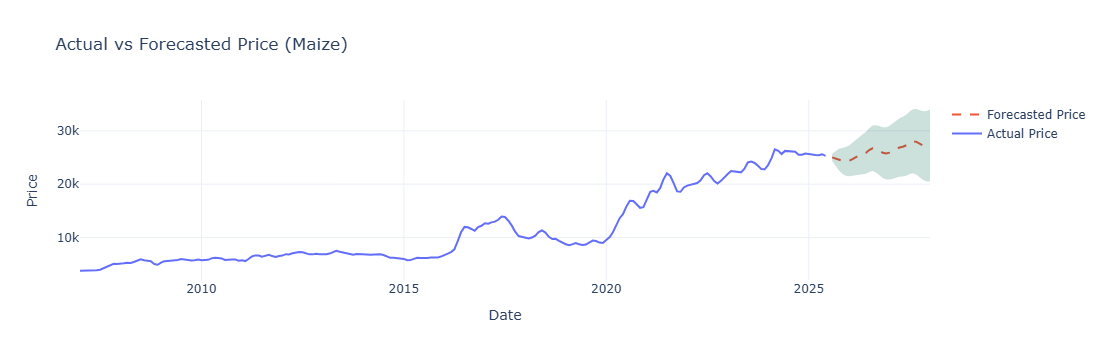

In [25]:
import plotly.graph_objects as go

fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(
    x=ts.index,
    y=ts['maize'],
    mode='lines',
    name='Actual Price'
))

# Forecasted data
fig.add_trace(go.Scatter(
    x=forecast_table['Date'],
    y=forecast_table['Forecast'],
    mode='lines',
    name='Forecasted Price',
    line=dict(dash='dash')
))

# Confidence interval (shaded)
fig.add_trace(go.Scatter(
    x=forecast_table['Date'],
    y=forecast_table['Upper CI'],
    mode='lines',
    name='Upper CI',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=forecast_table['Date'],
    y=forecast_table['Lower CI'],
    mode='lines',
    name='Lower CI',
    fill='tonexty',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(width=0),
    showlegend=False
))

fig.update_layout(
    title="Actual vs Forecasted Price (Maize)",
    xaxis_title="Date",
    yaxis_title="Price",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()
